In [1]:
import pandas as pd

file_path = r"C:\ProgramData\MySQL\MySQL Server 8.0\Uploads\Caribbean_countries_by_population.csv"
df = pd.read_csv(file_path)

df.head()


,Rank,Country / dependency,% Total,UN 2023estimate,% change,Official figure,Official date
0,1,Haiti,25.0%,"11,724,764",1.2%,"9,801,664",1 Jul 2012[2]
1,2,Dominican Republic,24.0%,"11,332,973",0.9%,"10,711,155",1 Jul 2023[3]
2,3,Cuba,24.0%,"11,194,449",-0.2%,"10,055,968",1 Dec 2023[4]
3,4,Puerto Rico (US),7.0%,"3,260,314",-1.6%,"3,203,295",1 Jul 2024[5]
4,5,Jamaica,6.1%,"2,825,544",-0.1%,"2,734,092",1 Jul 2019[6]


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Rank                  29 non-null     object
 1   Country / dependency  29 non-null     object
 2   % Total               29 non-null     object
 3   UN 2023estimate       29 non-null     object
 4   % change              29 non-null     object
 5   Official figure       28 non-null     object
 6   Official date         28 non-null     object
dtypes: object(7)
memory usage: 1.7+ KB


In [3]:
import numpy as np
import re

# -----------------------------
# 1. Rename columns
# -----------------------------
df = df.rename(columns={
    "Rank": "rank",
    "Country / dependency": "country_dependency",
    "% Total": "percent_total",
    "UN 2023estimate": "un_2023_estimate",
    "% change": "percent_change",
    "Official figure": "official_figure",
    "Official date": "official_date"
})

# -----------------------------
# 2. Clean numeric fields
# -----------------------------
def clean_numeric(x):
    if pd.isna(x):
        return np.nan
    x = re.sub(r"\[.*?\]", "", str(x))  # remove footnotes
    x = x.replace(",", "").replace("%", "").strip()
    return x

numeric_cols = ["rank", "percent_total", "un_2023_estimate", "percent_change", "official_figure"]

for col in numeric_cols:
    df[col] = df[col].apply(clean_numeric)
    df[col] = pd.to_numeric(df[col], errors="coerce")

# -----------------------------
# 3. Clean date column
# -----------------------------
df["official_date"] = (
    df["official_date"]
    .astype(str)
    .str.replace(r"\[.*?\]", "", regex=True)
    .str.strip()
    .replace("nan", np.nan)
)

# Extract year if possible
df["official_year"] = df["official_date"].str.extract(r"(\d{4})").astype("float")

# -----------------------------
# 4. Feature Engineering
# -----------------------------

# 4.1 Dependency flag
df["is_dependency"] = df["country_dependency"].str.contains(r"\(", regex=True).astype(int)

# 4.2 Extract admin power (UK, France, Netherlands, Independent)
def extract_admin_power(name):
    if "(UK" in name:
        return "United Kingdom"
    if "(France" in name:
        return "France"
    if "(Netherlands" in name:
        return "Netherlands"
    return "Independent"

df["admin_power"] = df["country_dependency"].apply(extract_admin_power)

# 4.3 Clean country name (remove parentheses)
df["country_clean"] = df["country_dependency"].str.replace(r"\(.*?\)", "", regex=True).str.strip()

# 4.4 Population gap (UN estimate - official)
df["population_gap"] = df["un_2023_estimate"] - df["official_figure"]

# 4.5 Accuracy ratio
df["accuracy_ratio"] = df["official_figure"] / df["un_2023_estimate"]

# 4.6 Growth flags
df["growth_flag"] = (df["percent_change"] > 0).astype(int)

# 4.7 Growth category
def growth_category(x):
    if pd.isna(x):
        return "Unknown"
    if x > 2:
        return "High growth"
    if x > 0:
        return "Moderate growth"
    if x == 0:
        return "Stable"
    return "Decline"

df["growth_category"] = df["percent_change"].apply(growth_category)

# 4.8 Missing data flags
df["missing_official_figure"] = df["official_figure"].isna().astype(int)
df["missing_official_date"] = df["official_date"].isna().astype(int)

# 4.9 Add region + year for star schema integration
df["region"] = "Caribbean"
df["year"] = 2023

# -----------------------------
# 5. Final ordering of columns
# -----------------------------
df = df[
    [
        "rank",
        "country_dependency",
        "country_clean",
        "is_dependency",
        "admin_power",
        "percent_total",
        "un_2023_estimate",
        "percent_change",
        "official_figure",
        "population_gap",
        "accuracy_ratio",
        "growth_flag",
        "growth_category",
        "official_date",
        "official_year",
        "missing_official_figure",
        "missing_official_date",
        "region",
        "year"
    ]
]

df.head()


,rank,country_dependency,country_clean,is_dependency,admin_power,percent_total,un_2023_estimate,percent_change,official_figure,population_gap,accuracy_ratio,growth_flag,growth_category,official_date,official_year,missing_official_figure,missing_official_date,region,year
0,1.0,Haiti,Haiti,0,Independent,25.0,11724764.0,1.2,9801664.0,1923100.0,0.835980,1,Moderate growth,1 Jul 2012,2012.0,0,0,Caribbean,2023
1,2.0,Dominican Republic,Dominican Republic,0,Independent,24.0,11332973.0,0.9,10711155.0,621818.0,0.945132,1,Moderate growth,1 Jul 2023,2023.0,0,0,Caribbean,2023
2,3.0,Cuba,Cuba,0,Independent,24.0,11194449.0,-0.2,10055968.0,1138481.0,0.898300,0,Decline,1 Dec 2023,2023.0,0,0,Caribbean,2023
3,4.0,Puerto Rico (US),Puerto Rico,1,Independent,7.0,3260314.0,-1.6,3203295.0,57019.0,0.982511,0,Decline,1 Jul 2024,2024.0,0,0,Caribbean,2023
4,5.0,Jamaica,Jamaica,0,Independent,6.1,2825544.0,-0.1,2734092.0,91452.0,0.967634,0,Decline,1 Jul 2019,2019.0,0,0,Caribbean,2023


In [4]:
output_path = r"C:\ProgramData\MySQL\MySQL Server 8.0\Uploads\Caribbean_countries_by_population_clean.csv"
df.to_csv(output_path, index=False)


In [5]:
sample_path = r"C:\ProgramData\MySQL\MySQL Server 8.0\Uploads\Caribbean_countries_by_population_first_30.csv"
df.head(30).to_csv(sample_path, index=False)


C:\Users\eguen\AppData\Local\Temp\ipykernel_21124\1952359537.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


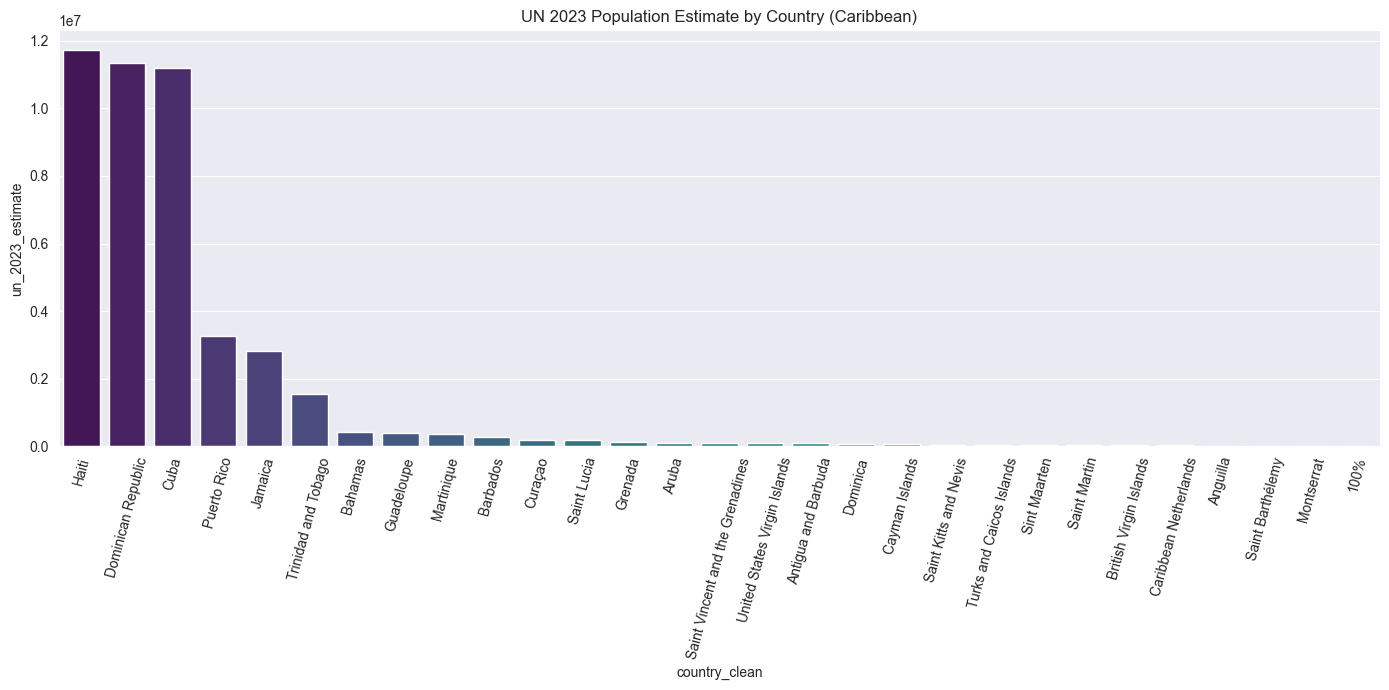

C:\Users\eguen\AppData\Local\Temp\ipykernel_21124\1952359537.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


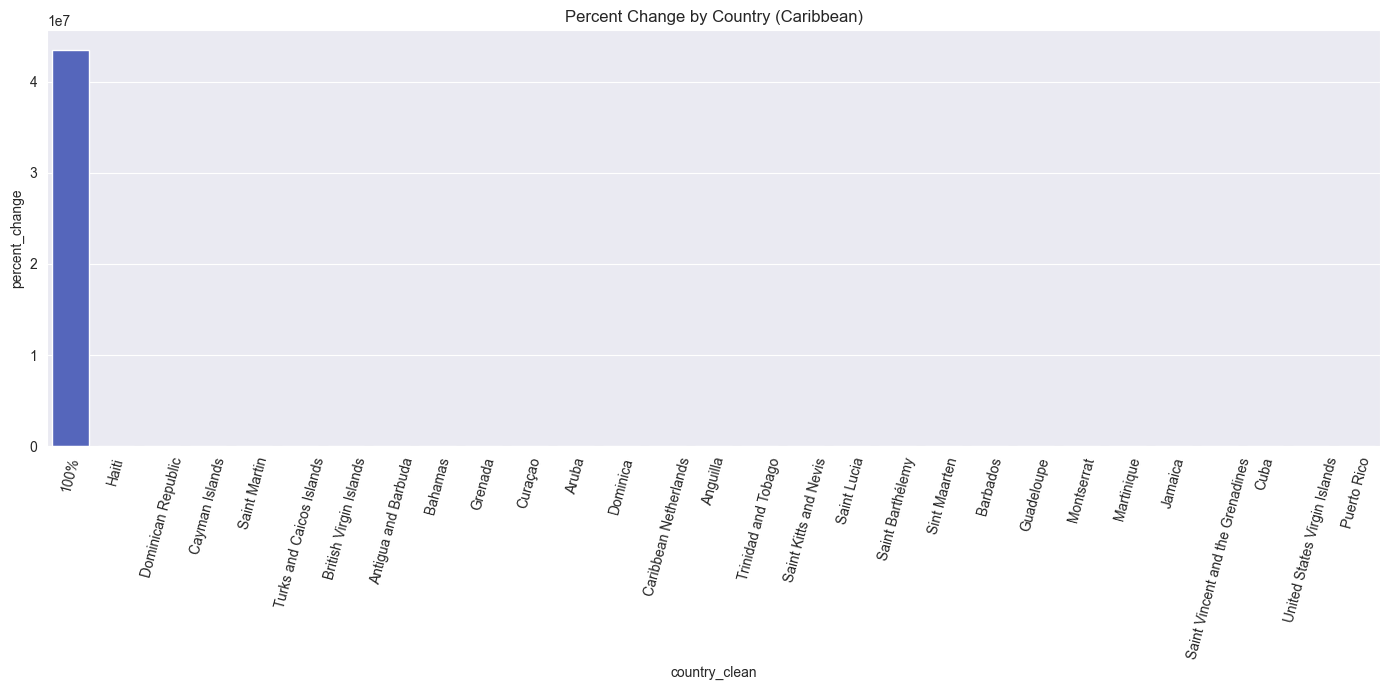

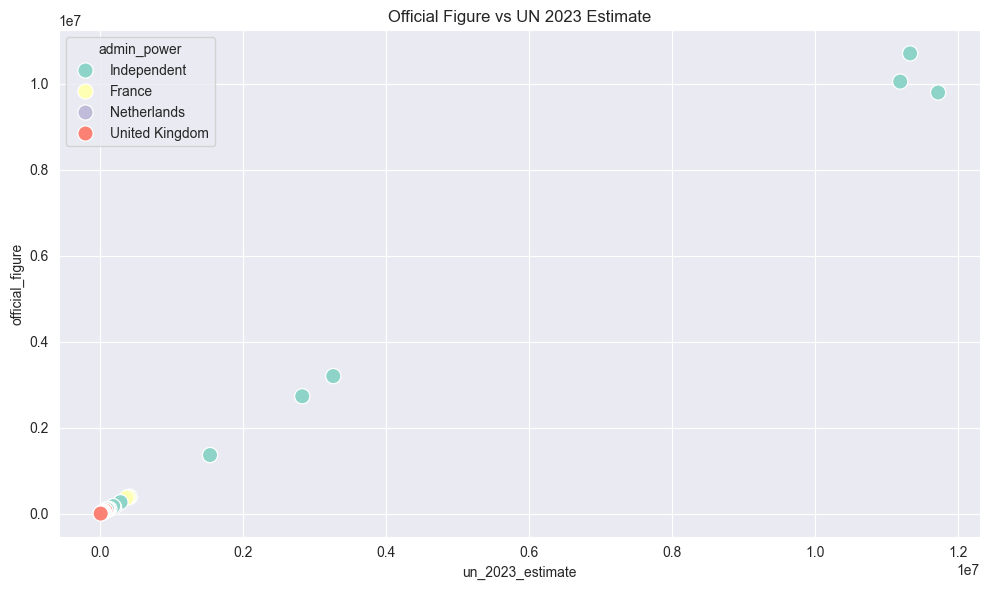

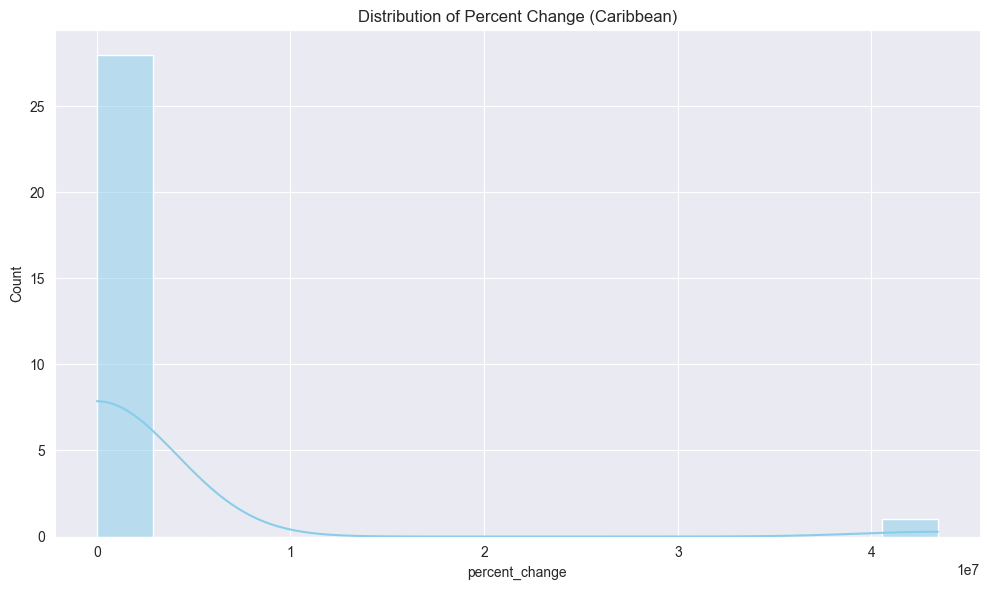

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Dark theme
plt.style.use("dark_background")
sns.set_style("darkgrid")

# Load dataset from your path
df = pd.read_csv(r"C:\ProgramData\MySQL\MySQL Server 8.0\Uploads\Caribbean_countries_by_population_clean.csv")

# -----------------------------
# 1. Bar chart – UN 2023 estimate
# -----------------------------
plt.figure(figsize=(14, 7))
sns.barplot(
    data=df.sort_values("un_2023_estimate", ascending=False),
    x="country_clean",
    y="un_2023_estimate",
    palette="viridis"
)
plt.xticks(rotation=75)
plt.title("UN 2023 Population Estimate by Country (Caribbean)")
plt.tight_layout()
plt.show()

# -----------------------------
# 2. Bar chart – Percent change
# -----------------------------
plt.figure(figsize=(14, 7))
sns.barplot(
    data=df.sort_values("percent_change", ascending=False),
    x="country_clean",
    y="percent_change",
    palette="coolwarm"
)
plt.xticks(rotation=75)
plt.title("Percent Change by Country (Caribbean)")
plt.tight_layout()
plt.show()

# -----------------------------
# 3. Scatter plot – Official vs UN estimate
# -----------------------------
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x="un_2023_estimate",
    y="official_figure",
    hue="admin_power",
    s=120
)
plt.title("Official Figure vs UN 2023 Estimate")
plt.tight_layout()
plt.show()

# -----------------------------
# 4. Histogram – Percent change distribution
# -----------------------------
plt.figure(figsize=(10, 6))
sns.histplot(df["percent_change"], kde=True, bins=15, color="skyblue")
plt.title("Distribution of Percent Change (Caribbean)")
plt.tight_layout()
plt.show()


In [8]:
import pandas as pd

# Load the cleaned dataset
df = pd.read_csv(r"C:\ProgramData\MySQL\MySQL Server 8.0\Uploads\Caribbean_countries_by_population_clean.csv")

# Remove the last row
df = df.iloc[:-1]

# Save it back to the same location
df.to_csv(r"C:\ProgramData\MySQL\MySQL Server 8.0\Uploads\Caribbean_countries_by_population_clean.csv", index=False)

print("Last row removed and file updated.")


Last row removed and file updated.
